In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import utils

plt.rcParams['figure.figsize'] = (12, 8)

/Users/mjain/DoSomething/data/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# set below variables according to how they're stored in your environ file
conn = utils.load_connection(db_user_env='DB_USER', db_pw_env='DB_PW', db_name_env='DB_NAME', db_host_env='DB_HOST')

In [4]:
mel_sql = '''
select *
from public.member_event_log
where "timestamp" between '2018-01-01' and '2018-11-01'
'''

In [5]:
if os.path.exists('member_event_log.csv.gz'):
    df_mel = pd.read_csv('member_event_log.csv.gz', compression='gzip', low_memory=False)
    df_mel['timestamp'] = pd.to_datetime(df_mel['timestamp'], utc=True)
else:
    df_mel = pd.read_sql(mel_sql, con=conn)
    df_mel['timestamp'] = pd.to_datetime(df_mel['timestamp'], utc=True)
    df_mel.to_csv('member_event_log.csv.gz', compression='gzip', index=False)

In [6]:
df_mel.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
0,5539d9a4de43b053e5ed1a6d750eca84,5add0474a0bfad7cd84aaf39,2018-04-22 21:58:35+00:00,post,2,importer-client,620990,other
1,fd97ac13beef2e1b62e276fc2bdfec34,5add04dba0bfad7cd84aaf3c,2018-04-22 21:58:58+00:00,post,2,importer-client,620988,other
2,411682d8311f51e8ae36a23addd58132,5add05b5a0bfad0302532120,2018-04-22 23:06:58+00:00,post,2,phoenix-next,464361,web
3,abc30a17eb3e18cf745b4c914c4b7af7,5add071ea0bfad030253212f,2018-04-22 22:06:20+00:00,post,2,importer-client,620986,other
4,5e74e7a0ae28f63784d71d006ddbc4e0,5add0765a0bfad0302532132,2018-04-22 22:21:17+00:00,post,2,importer-client,620977,other


## Look at fields with null values.

In [7]:
# print each column and number of null values
utils.print_null_vals(df_mel)

,col,num_null,percent_null
0,event_id,0,0.000000
1,northstar_id,140,0.000019
2,timestamp,140,0.000019
3,action_type,0,0.000000
4,action_id,0,0.000000
5,source,1217794,0.166543
6,action_serial_id,1608620,0.219991
7,channel,0,0.000000


### NS IDs

In [8]:
df_mel[(df_mel['northstar_id'].isnull()) | (df_mel['northstar_id'] == '')].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
2119964,53e15060db70b1d56167f1bbd717bfa8,NaN,2018-05-26 09:41:35+00:00,clicked_link,7,1,01CEDX68XVTV6ZCHGQDVTZF7H5,email
2180952,9f26aaab8358db78e5d630099d4f105e,NaN,2018-06-26 11:44:17+00:00,clicked_link,7,4,01CGXYH8935N409HG5P12GF8X1,email
2195257,29fd201ef1767c26371ebdb21bcc5922,NaN,2018-08-06 15:33:55+00:00,clicked_link,7,3,01CM7XZ60EMREMEQ80X0EHHSFD,email
2327215,120dd53b7105561e380a4dac44223868,NaN,2018-07-26 21:54:10+00:00,clicked_link,7,1,01CKC9BHQZPBZXXRBYXYMCWEAT,email
2333671,09f04d7d2c7855e0ebe3a5bd2918193f,NaN,2018-08-24 08:52:58+00:00,clicked_link,7,2,01CNNJ5Z0E9GH8P23FXJAYFYHN,email
2534779,d442154bd9c93a4a66cc6bed261ef979,NaN,2018-05-28 10:57:27+00:00,clicked_link,7,1,01CEK6AN9Y1QAC1YF5PBSENFCW,email
2652859,b58ec6356eea61921a6051ae80b28cac,NaN,2018-07-27 18:52:56.690540+00:00,bertly_link_uncertain,10,bertly,527b3c63-2d46-45a9-898f-9c513bd4c8d1,web
2652860,e8b4c7d2cd7854e56a075f52ad16dcfd,NaN,2018-07-27 19:16:01.808868+00:00,bertly_link_uncertain,10,bertly,dabb85b1-c58c-4bcb-8f84-55c7ea566916,web
2652861,e959faae9250cf59575a848bb2778472,NaN,2018-07-27 20:06:12.538669+00:00,bertly_link_uncertain,10,bertly,01a2857f-e7fc-4d32-8d20-7abb2edf2ad9,web
2652862,8c40dedeb81eed926ea6c335cae11dcc,NaN,2018-07-27 20:30:16.998055+00:00,bertly_link_uncertain,10,bertly,12c19a30-6dba-43b5-a77c-f853bb3499e3,web


In [9]:
df_mel[(df_mel['northstar_id'].isnull()) | (df_mel['northstar_id'] == '')]['action_type'].value_counts()

bertly_link_uncertain    100
bertly_link_click         33
clicked_link               6
bertly_link_preview        1
Name: action_type, dtype: int64

Is this related to the known issue of when pulling the northstar_id from a url string for bertly fails? Is there a way to safeguard against this?

### Source

In [10]:
df_mel[df_mel['source'].isnull()]['action_type'].value_counts()

site_access    654970
site_login     532913
signup          29910
post                1
Name: action_type, dtype: int64

In [11]:
df_mel[(df_mel['source'].isnull()) & (df_mel['action_type'] == 'signup')].head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
4954716,3c9e026bea0c3fe8f81a398b0f957868,554e678a469c64ec7d8b655d,2018-01-25 14:31:34+00:00,signup,1,NaN,8623767,web
4954717,135c318c949c59f91d9880813da5ef8f,55632554469c6430068b7e00,2018-06-23 00:33:52+00:00,signup,1,NaN,9282988,web
4954718,7d4be20a57890ebf5244773d3360d4be,5594c41d469c64d53d8b5e9e,2018-03-05 21:56:12+00:00,signup,1,NaN,8872055,web
4954719,2563ead0fb08a5f747d5ea2bfdedd69e,55a7efbc469c64022e8e2dbd,2018-01-28 10:54:53+00:00,signup,1,NaN,8637201,web
4954720,4dfc5a0efdd785ef04cfe6e7916da0d9,55a869fe469c649e2b8fb941,2018-08-22 02:19:52+00:00,signup,1,NaN,9408787,web


In [12]:
df_mel_check = df_mel[
    (df_mel['source'].isnull()) & (df_mel['action_type'] == 'signup')].set_index('timestamp').groupby(
    [pd.Grouper(freq='W')]
).agg({'northstar_id': lambda x: len(x.unique())})

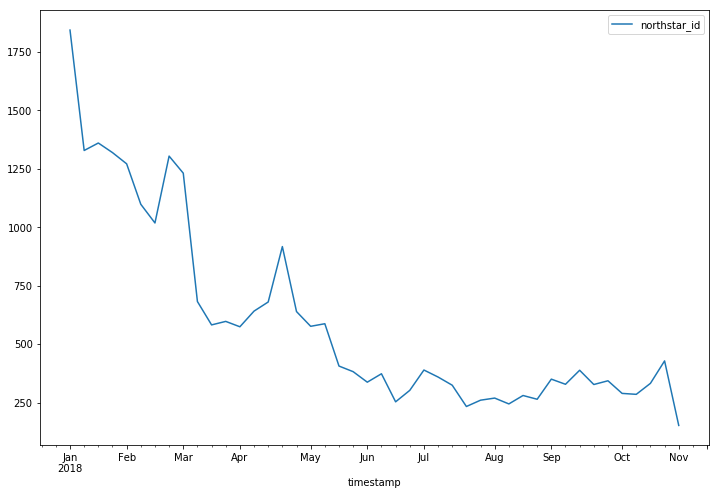

In [13]:
df_mel_check.plot();

<b>Question:</b> According to MEL sql logic, campaign signups and posts can also have a null source, in which case the channel is web. What cases is this capturing, and why has this occurrence decreased over time? 
- Biggest offenders according to rogue.signups are campaign_ids 3590 (8,402 unique ns ids), 2063 (1,342), 7822 (985) 

### Action_serial_id

In [14]:
df_mel[df_mel['action_serial_id'] == '0']['action_type'].value_counts()

site_access         654970
site_login          532913
account_creation    420737
Name: action_type, dtype: int64

The above action types are expected.

## Duplicates

In [15]:
# The only single column I expect to be unique is the event_id, which it looks like they are.
df_mel[df_mel.duplicated('event_id')]

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel


In [16]:
# Another expectation might be the northstar_id, action_type, action_serial_id combination should be unique because
# the action_serial_id should be unique to a post/signup (given that Quasar keeps a log of posts/signups rather than 
# overwriting when updated as in Rogue)
df_dupes = df_mel[df_mel.duplicated(
    ['northstar_id', 'action_type', 'action_serial_id'], keep=False)].sort_values(['northstar_id', 'timestamp'])

# removing site access and site logins because action_serial_id always set to 0 and duplicates expected
df_dupes = df_dupes[~((df_dupes['action_type'] == 'site_login')| (df_dupes['action_type'] == 'site_access'))]

In [17]:
df_dupes.head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
2052720,bcc41300bad974ec14a86ff80913c70d,5543c402469c64bf3d8b457f,2018-04-02 16:27:40+00:00,clicked_link,7,1,01CA42ETJF84VBMFCDTJMP9CKN,email
2485906,dfeb58a177a8fde32101d4cd19565537,5543c402469c64bf3d8b457f,2018-04-02 20:27:40+00:00,clicked_link,7,1,01CA42ETJF84VBMFCDTJMP9CKN,email
2629310,c4ab979dd06c10f202be324562bdd960,5543eafd469c64bf3d8b4653,2018-04-02 16:30:38+00:00,clicked_link,7,1,01CA42QWR3JWM48C6J79J8HWSM,email
2491011,09e7710af9e9b0dff26e23bdefb0aa56,5543eafd469c64bf3d8b4653,2018-04-02 20:30:38+00:00,clicked_link,7,1,01CA42QWR3JWM48C6J79J8HWSM,email
2122663,573484a129f536728ecd3be53fdfb7d8,5543fb9c469c64ec7d8b4733,2018-03-20 18:23:26+00:00,clicked_link,7,1,01C92RB7EMNHQ6H8BX6JMZ0R3F,email
2070459,1f69162d8aa20bf1d8a81ae273c978c9,5543fb9c469c64ec7d8b4733,2018-03-20 22:23:26+00:00,clicked_link,7,1,01C92RB7EMNHQ6H8BX6JMZ0R3F,email
2210074,ca8ef418320081cb8e7cc75ead5886eb,5543fb9c469c64ec7d8b4733,2018-03-24 08:55:14+00:00,clicked_link,7,1,01C9C1W6G37DGV586BSBYAKJ47,email
2305976,89a322a9c6ee8a6b144ec56dc75471ff,5543fb9c469c64ec7d8b4733,2018-03-24 12:55:14+00:00,clicked_link,7,1,01C9C1W6G37DGV586BSBYAKJ47,email
2373583,391d520feffa4a62f517be2464a18de9,5543fb9c469c64ec7d8b4733,2018-03-28 13:21:46+00:00,clicked_link,7,1,01C9PT35QKZX6MSHH1E9NSGYH5,email
2413891,701e33b7b94583a39115af4d1674c8a7,5543fb9c469c64ec7d8b4733,2018-03-28 17:21:46+00:00,clicked_link,7,1,01C9PT35QKZX6MSHH1E9NSGYH5,email


In [18]:
df_dupes['northstar_id'].value_counts().head(10)

56dad08d469c64d8578b4f14    74
56daa439469c6444628b4d95    72
56dafb96469c6444628b4db5    66
56db2b2d469c64d8578b4f64    64
5a9b23f2a0bfad2e34699896    24
59dbaa60a0bfad082a6207c2    22
5a517200a0bfad6541202414    22
59d2b090a0bfad02a813b46a    20
59d7a716a0bfad17256c8e5a    20
5a5ee751a0bfad793c61883b    20
Name: northstar_id, dtype: int64

In [19]:
df_dupes['channel'].value_counts()

email    59120
Name: channel, dtype: int64

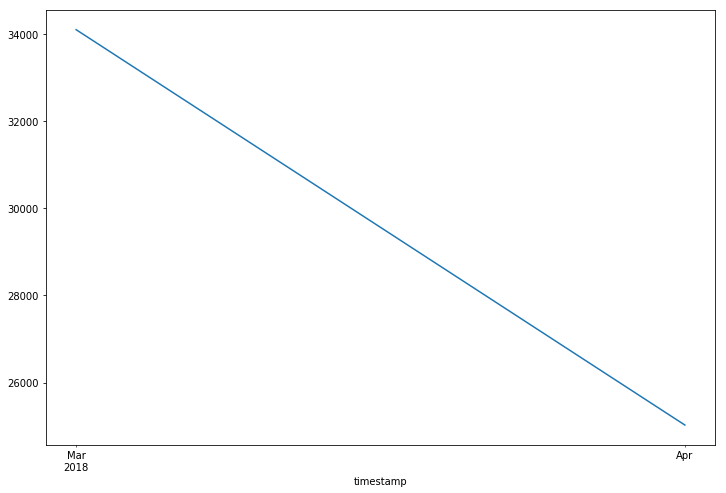

In [20]:
df_dupes.set_index('timestamp').groupby(pd.Grouper(freq='M'))['northstar_id'].count().plot()

<b> Action Item</b>: Why are there email duplicates where one timestamp is exactly 4 hours ahead of the other? This only seems to be an issue in Mar/April.

In [21]:
# Another combination of fields that should potentially be unique are NS ids, timestamps, and action types.
# In which case, how were different action_serial_ids generated?
df_dupes2 = df_mel[df_mel.duplicated(
    ['northstar_id', 'timestamp', 'action_type'], keep=False)].sort_values(['northstar_id', 'timestamp'])

In [22]:
df_dupes2.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
2654751,38529c9b4577f02fa315112e3ab8a785,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.829585+00:00,bertly_link_uncertain,10,bertly,1133f90c-6485-408a-976a-d04cd3bf023f,sms
2654752,550a5e755608beaf5a2162ce8d85fdff,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.829585+00:00,bertly_link_uncertain,10,bertly,f5a614a0-0f57-4420-b57c-d555971431fe,sms
2654777,8d8ea32998fd5032c14f9799d4b883c3,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.887231+00:00,bertly_link_uncertain,10,bertly,26d61671-708b-4334-be52-84621c0ef3fd,sms
2654778,92d443681cf6766c5de3cbe5a9cdabcb,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:51.887231+00:00,bertly_link_uncertain,10,bertly,c04cf487-3e6b-4ebb-9450-0ca3e87f446a,sms
2655988,ac6af34ab0c18bfe4451bd8410bf86ac,5543dfd6469c64ec7d8b46b3,2018-06-07 18:14:59.462954+00:00,bertly_link_uncertain,10,bertly,38c85408-3ae4-450f-b965-db839b538e06,sms


In [23]:
# It seems like many of these are related to bertly clicks occuring before user agent strings were being captured.
df_dupes2['source'].value_counts()

SMS                26839
phoenix-next        3186
1                    816
sms                  624
bertly               528
2                    377
turbovote            130
7                     16
8                      8
campaigns              6
niche                  4
3                      3
5                      2
9                      2
importer-client        2
rock-the-vote          2
Name: source, dtype: int64

### SMS / Gambit

In [24]:
df_dupes2[df_dupes2['source'] == 'SMS'].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
486821,739f12045d1ecf17a8a2732d9bb9fecb,554764a5469c64ed7d8b4f68,2018-09-06 16:46:12+00:00,messaged_gambit,6,SMS,5b9159d456e5e3000464c27b,sms
486822,c17d6cb0d5a1d5a4226da07d228227e2,554764a5469c64ed7d8b4f68,2018-09-06 16:46:12+00:00,messaged_gambit,6,SMS,5b9159d4b18c6a00040e9af5,sms
486823,55efd06a0059facd88f04a7c67325106,554764a5469c64ed7d8b4f68,2018-09-06 16:46:12+00:00,messaged_gambit,6,SMS,5b9159d4e309ed00043830ab,sms
486881,9c0894a88ebf17324dd2d5eb0cccc910,55479986469c64ec7d8b5085,2018-01-31 03:14:48+00:00,messaged_gambit,6,SMS,5a7134a83fa8aa0004713f15,sms
486882,8fc7070a954995cc6b650a804fd8a2f5,55479986469c64ec7d8b5085,2018-01-31 03:14:48+00:00,messaged_gambit,6,SMS,5a7134a86cfd310004722717,sms
486890,79b001a997767cd145df933c3f7a51bc,55479986469c64ec7d8b5085,2018-08-28 19:39:59+00:00,messaged_gambit,6,SMS,5b85a50f4b53610004be5039,sms
486891,8f3861df198a6e9606ad3af6662c8c2e,55479986469c64ec7d8b5085,2018-08-28 19:39:59+00:00,messaged_gambit,6,SMS,5b85a50fce46d90004536742,sms
487887,4b3c6ab8854586d55a9d8862e6c144cd,554a0e2c469c64bf3d8b5860,2018-01-23 21:05:09+00:00,messaged_gambit,6,SMS,5a67a3856340af00043e3306,sms
487888,2d79d555a152cf14c1208a9354108ee2,554a0e2c469c64bf3d8b5860,2018-01-23 21:05:09+00:00,messaged_gambit,6,SMS,5a67a3858d3c0c000475932d,sms
489182,838ceab434a94a5ae0981fbb6784fca5,5554cb62469c6455048b4570,2018-09-19 17:48:32+00:00,messaged_gambit,6,SMS,5ba28bf02217640004b60f65,sms


In [25]:
id_str = ''
all_ids = df_dupes2[df_dupes2['source'] == 'SMS']['northstar_id'].unique()
for pos, idx in enumerate(all_ids):
    if pos == (len(all_ids) - 1):
        id_str += '\'' + str(idx) + '\''
    else:
        id_str += '\'' + str(idx) + '\', '
        
gambit_sql_str = '''
SELECT *
FROM public.gambit_messages_inbound
WHERE user_id IN ({})
AND macro = 'subscriptionStatusStop' 
'''.format(id_str)

df_gambit_check = pd.read_sql(gambit_sql_str, con=conn)

In [26]:
len(df_gambit_check['user_id'].unique())

918

In [27]:
df_gambit_check['user_id'].unique()[:10]

array(['5994f70ea0bfad1de92f361d', '57f8a1dd42a064025b8b484c',
       '5580d2c7469c6475138b501b', '58bb70c6a0bfad1dc913383c',
       '57f8a37a42a064085b8b48a3', '5876b699a0bfad51b9208cc1',
       '58b0932da0bfad7aba26248d', '58ba4043a0bfad4b2c789c31',
       '58890ca0a0bfad46df0bb06b', '58ba857ba0bfad5f21676315'],
      dtype=object)

In [28]:
gambitupdate_sql = '''
SELECT a1.*
FROM
(SELECT
    MD5(concat(a.northstar_id, a."timestamp", a.action_id, a.action_serial_id)) AS event_id,
    a.northstar_id AS northstar_id,
    a."timestamp" AS "timestamp",
    a."action" AS action_type,
    a.action_id AS action_id,
    a."source" AS "source",
    a.action_serial_id AS action_serial_id,
    a.channel AS channel
FROM ( 
    SELECT -- LAST MESSAGED SMS 
        DISTINCT g.user_id AS northstar_id,
        g.created_at AS "timestamp",
        'messaged_gambit' AS "action", 
        '6' AS action_id,
        'SMS' AS "source",
        g.message_id AS action_serial_id,
        'sms' AS "channel"
    FROM
        public.gambit_messages_inbound g
    WHERE 
    	g.user_id IS NOT NULL
    	AND g.macro <> 'subscriptionStatusStop'
    	AND g.macro <> 'declinedCampaign'
    ) AS a
) a1
WHERE a1."timestamp" between '2018-01-01' and '2018-11-01'
; 
'''
df_mel_gambitupdate = pd.read_sql(gambitupdate_sql, con=conn)

In [29]:
df_mel_gambitremoved = df_mel[~(df_mel['action_type'] == 'messaged_gambit')]

In [30]:
df_mel_gambitremoved['timestamp'] = pd.to_datetime(df_mel_gambitremoved['timestamp'], utc=True)

/Users/mjain/DoSomething/data/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
df_mel_gambitcheck = pd.concat([df_mel_gambitremoved, df_mel_gambitupdate], axis=0)

In [32]:
df_mel_gambitcheck.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
0,5539d9a4de43b053e5ed1a6d750eca84,5add0474a0bfad7cd84aaf39,2018-04-22 21:58:35+00:00,post,2,importer-client,620990,other
1,fd97ac13beef2e1b62e276fc2bdfec34,5add04dba0bfad7cd84aaf3c,2018-04-22 21:58:58+00:00,post,2,importer-client,620988,other
2,411682d8311f51e8ae36a23addd58132,5add05b5a0bfad0302532120,2018-04-22 23:06:58+00:00,post,2,phoenix-next,464361,web
3,abc30a17eb3e18cf745b4c914c4b7af7,5add071ea0bfad030253212f,2018-04-22 22:06:20+00:00,post,2,importer-client,620986,other
4,5e74e7a0ae28f63784d71d006ddbc4e0,5add0765a0bfad0302532132,2018-04-22 22:21:17+00:00,post,2,importer-client,620977,other


In [33]:
reg_numbers = df_mel.set_index('timestamp').groupby(pd.Grouper(freq='M')).agg(
    {'northstar_id': lambda x: len(x.unique())})

gambitupdate_numbers = df_mel_gambitcheck.set_index('timestamp').groupby(pd.Grouper(freq='M')).agg(
    {'northstar_id': lambda x: len(x.unique())})

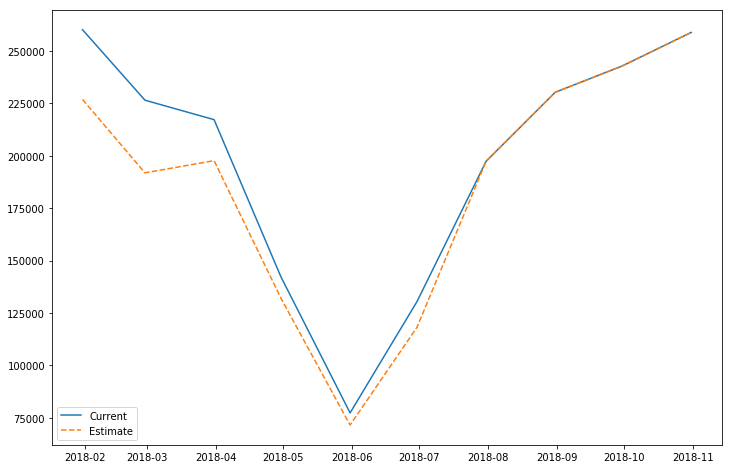

In [34]:
plt.plot(reg_numbers, label='Current')
plt.plot(gambitupdate_numbers, label='Estimate', linestyle='--')
plt.legend()

In [35]:
((gambitupdate_numbers - reg_numbers) / reg_numbers).mean()

northstar_id   -0.061124
dtype: float64

<b> No Action: </b> Duplicates here tend to be multi-part messages and not actual duplicates. 

<b> Action Item: </b> There is some user error around unsubscribing (e.g. NS ID = '554764a5469c64ed7d8b4f68'), where the user attempts to unsubscribe multiple times unsuccessfully. Consider flagging.

<b> Possible Action Item: </b> I spotchecked Gambit conversation flows for around 10-12 of the 918 northstar_ids from above, and at least 75% were purely attempts to unsubscribe and included many 'declinedCampaign' statuses. It's probably not worth the effort to filter out these users. One proxy might be to exclude 'declinedCampaign', in which case the impact would be on average a 6% drop in MAMs over the year and no change for the past 3 months.

### Phoenix Next / SMS posts

In [36]:
df_dupes2[df_dupes2['source'] == 'sms'].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
7229663,8b24147e00acc5e0bb225719f948eaa5,555520c4469c6430068b4dc5,2018-06-07 23:25:41+00:00,post,2,sms,540852,sms
7229664,40b695f9512f351574ebf0c5ccb4558d,555520c4469c6430068b4dc5,2018-06-07 23:25:41+00:00,post,2,sms,540853,sms
7229856,3118f630d80077c1e0f7067425ca3d86,55693e18469c6430068b9391,2018-06-07 20:17:53+00:00,post,2,sms,535116,sms
7229857,2ddd8191dc759f372cec6cc6401075c1,55693e18469c6430068b9391,2018-06-07 20:17:53+00:00,post,2,sms,535117,sms
7230012,4820f921a642774d30fdf1348bea059a,556f88c5469c64a1208b49ae,2018-06-07 19:25:28+00:00,post,2,sms,533287,sms
7230013,6d4458f10b2149c15c02c95b68f0389e,556f88c5469c64a1208b49ae,2018-06-07 19:25:28+00:00,post,2,sms,533288,sms
7230098,1c7eed0435fd64f4f3f5851ca2475660,5574ae92469c64f4768b4e75,2018-06-07 19:32:58+00:00,post,2,sms,533496,sms
7230099,637d55d86a7477c43fed126ae6371779,5574ae92469c64f4768b4e75,2018-06-07 19:32:58+00:00,post,2,sms,533497,sms
7230392,13a7eef8210bb7ca7da8afe8afb985b6,5589acc5469c6474138b7f4c,2018-06-08 02:05:14+00:00,post,2,sms,541991,sms
7230393,53145e8e7b0c65fa01d226180a47b369,5589acc5469c6474138b7f4c,2018-06-08 02:05:14+00:00,post,2,sms,541992,sms


In [37]:
df_dupes2[df_dupes2['source'] == 'phoenix-next'].head(10)

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel
6155533,eb62e4712946498a7fed9eaf248f4a44,5553747b469c64ec7d8b7372,2018-07-10 06:16:40+00:00,signup,1,phoenix-next,9312378,web
6155534,3311b33cba6ffdb2dc7a580fa2811531,5553747b469c64ec7d8b7372,2018-07-10 06:16:40+00:00,signup,1,phoenix-next,9312379,web
6157655,29db0b222449f2862b469fa6770b70d7,556b59fb469c6416048b9ba2,2018-06-22 23:23:28+00:00,signup,1,phoenix-next,9282903,web
6157656,10221fd753559aaa2d58ba776e8f28ed,556b59fb469c6416048b9ba2,2018-06-22 23:23:28+00:00,signup,1,phoenix-next,9282904,web
6159861,c7de5a4600dd49556daebd594187863b,5574aaac469c648c778b4c9c,2018-07-10 15:00:05+00:00,signup,1,phoenix-next,9312852,web
6159862,579b96d61b0655ea2a1f9c25b7b6686b,5574aaac469c648c778b4c9c,2018-07-10 15:00:05+00:00,signup,1,phoenix-next,9312853,web
6160562,a08fabcc8257c76dddcfba50c216c8fc,5579e3c0469c648c778b6184,2018-08-08 06:13:33+00:00,signup,1,phoenix-next,9377474,web
6160563,5d508064daacb4bf32bac4b536752e17,5579e3c0469c648c778b6184,2018-08-08 06:13:33+00:00,signup,1,phoenix-next,9377475,web
6160990,819b95ddc4d71d1f4666e79f5dd34ef8,557f1089469c648c778b6f7f,2018-03-14 02:42:02+00:00,signup,1,phoenix-next,8961794,web
6160991,9d181f262db87d9ce0c6cb10d072faf8,557f1089469c648c778b6f7f,2018-03-14 02:42:02+00:00,signup,1,phoenix-next,8961795,web


In [38]:
dupe_signup_count_sql = '''
SELECT DATE_TRUNC('month', updated_at) as month, count(*) as num_dupes
FROM (
	SELECT northstar_id, campaign_id, campaign_run_id, "source", updated_at, count(*)
	FROM rogue.signups
    WHERE created_at between '2018-01-01' and '2018-11-01'
	GROUP BY northstar_id, campaign_id, campaign_run_id, "source", updated_at
	HAVING COUNT(*) > 1
	ORDER BY northstar_id, campaign_id, updated_at
) a
GROUP BY DATE_TRUNC('month', a.updated_at)
ORDER BY DATE_TRUNC('month', a.updated_at);
'''

df_dupe_signup_count = pd.read_sql(dupe_signup_count_sql, con=conn, index_col='month')

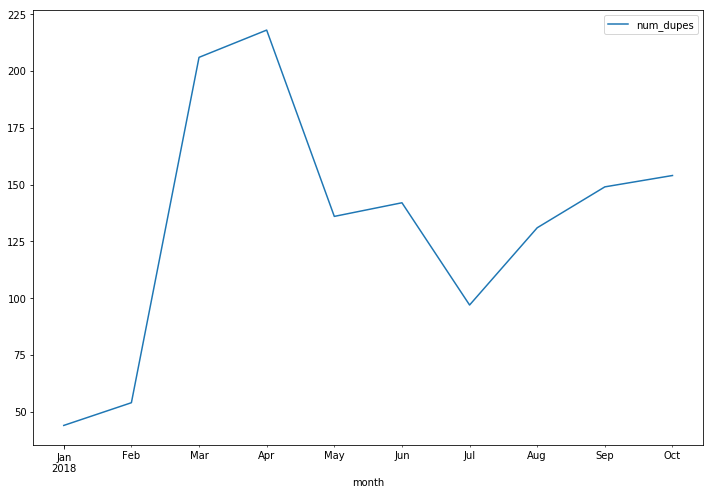

In [39]:
df_dupe_signup_count.plot();

<b> No action: </b> Post duplicates are multi-part messages. But, do we want to store multiple parts of a message as separate posts? Does it matter for reportbacks?

<b> Action Item: </b> Some of the signup duplicates are not actual duplicates (they differ by campaign_id). The number of identical duplicates are plotted above. This will not affect MAMs but might be worth flagging if it's unexpected behavior.

### Look at action_type and channel combinations

In [40]:
df_mel.groupby(['channel', 'action_type']).agg({'northstar_id': lambda x: len(x.unique())})

northstar_id
channel              action_type                        
email                clicked_link                 123749
                     signup                           24
niche_coregistration account_creation              99290
                     signup                       112739
other                account_creation               1799
                     post                          42569
sms                  account_creation               7052
                     bertly_link_click            159841
                     bertly_link_preview          176128
                     bertly_link_uncertain        142240
                     messaged_gambit              464408
                     post                          14107
                     signup                       286792
web                  account_creation             312596
                     bertly_link_click              1380
                     bertly_link_preview               5
                     bertly_link_uncertain          2243
                     post                         145779
                     signup                       353677
                     site_access                  385335
                     site_login                   385837

In [41]:
df_mel[(df_mel['channel'] == 'other') & (df_mel['action_type'] == 'account_creation')]['source'].value_counts()

northstar          838
GDPR               722
runscope-client    229
rogue-oauth          8
aurora-oauth         1
nightwing-oauth      1
Name: source, dtype: int64

In [42]:
df_mel[(df_mel['channel'] == 'other') & (df_mel['action_type'] == 'post')]['source'].value_counts()

importer-client    57084
rogue-admin           43
rogue-oauth           38
Name: source, dtype: int64

<b>Action Item:</b> What can we clean up from the below?    

- Other + account_creation: GDPR, -oauth, and runscope-client sources? Is northstar okay?
- Other + post: rogue-oauth, rogue-admin, importer-client
- Web + bertly actions: I know that this is intended based on the target URL, but I guess it's not necessarily clear what source means (e.g. a link sourced from web vs email but sent via SMS?).

### Check User ID consistency

In [43]:
def find_length(x):
    if isinstance(x, float):
        return 0
    else:
        return len(x)

In [44]:
df_mel['len_ns_id'] = df_mel['northstar_id'].apply(find_length)

In [45]:
df_mel['len_ns_id'].describe()

count    7.312195e+06
mean     2.399855e+01
std      1.146491e-01
min      0.000000e+00
25%      2.400000e+01
50%      2.400000e+01
75%      2.400000e+01
max      2.400000e+01
Name: len_ns_id, dtype: float64

In [46]:
df_mel[df_mel['len_ns_id'] != 24]['len_ns_id'].value_counts()

22    3611
0      140
5        2
6        1
Name: len_ns_id, dtype: int64

In [47]:
df_mel[df_mel['len_ns_id'] != 24]['action_type'].value_counts()

bertly_link_uncertain    3169
bertly_link_preview       492
bertly_link_click          87
clicked_link                6
Name: action_type, dtype: int64

In [48]:
df_mel[df_mel['len_ns_id'] != 24]['channel'].value_counts()

sms      3618
web       130
email       6
Name: channel, dtype: int64

<b> Action Item: </b> Is this a known issue or related to the way that NS gets pulled for bertly table?

### Check source values

In [49]:
source_counts = df_mel.groupby(['action_type', 'source'])['northstar_id'].count()

In [51]:
for idx in source_counts.index.levels[0]:
    if idx not in ['site_access', 'site_login', 'bertly_link_click', 'bertly_link_preview', 'bertly_link_uncertain']:
        print(idx)
        print(source_counts[idx], '\n')

account_creation
source
GDPR                  722
aurora-oauth            1
niche               99290
nightwing-oauth         1
northstar             838
phoenix-next       279629
phoenix-oauth       32967
rogue-oauth             8
runscope-client       229
sms                  7052
Name: northstar_id, dtype: int64 

clicked_link
source
1    316423
2    263782
3     18142
4       265
5        98
6       305
7      6488
8      3600
9      3219
Name: northstar_id, dtype: int64 

messaged_gambit
source
SMS    1554350
Name: northstar_id, dtype: int64 

post
source
importer-client    57084
phoenix-ashes         19
phoenix-next       72005
phoenix-web          250
rock-the-vote      90375
rogue-admin           43
rogue-oauth           38
sms                18835
turbovote          14892
Name: northstar_id, dtype: int64 

signup
source
11facts                   1
campaigns              6511
dev-oauth                 1
ds_scholarship          483
email                    24
fastweb            

Could this use some cleanup?

### RTV Data Ingestion - Estimated Impact 

#### NOTE: This has already been cleaned up so the below analysis is now stale. If you'd like to reproduce the graphs below, I can provide a snapshot of MEL activity pre-cleaning.

Compare RTV counts by import date vs. registered date to see the extent to which MAM might be inflated.

In [38]:
ca_vote_sql = '''
select *
from public.campaign_activity
where signup_created_at between '2018-01-01' and '2018-11-01' 
'''

df_ca = pd.read_sql(ca_vote_sql, con=conn)

In [39]:
# should signup source be importer-client for these rows in campaign activity, or rock-the-vote? 
df_ca[(df_ca['post_source'] == 'rock-the-vote')]['signup_source'].value_counts()

rock-the-vote      155835
phoenix-next         6513
sms                  2930
importer-client        18
Name: signup_source, dtype: int64

In [40]:
df_mel[df_mel['source'] == 'rock-the-vote']['action_type'].value_counts()

post      161312
signup    151984
Name: action_type, dtype: int64

In [41]:
df_mel[(df_mel['action_type'] == 'signup') & (
    df_mel['source'] == 'rock-the-vote')]['northstar_id'].value_counts().head()

5bb98041664abb00bc335482    2
5ba55d264a047f008c54cae7    2
5bc8fd6e92f7af00ce77b615    2
5bca09c292f7af00a9432456    2
5bd04a8f3f4bdf00b82d4484    2
Name: northstar_id, dtype: int64

In [42]:
df_mel[(df_mel['action_type'] == 'signup') & (df_mel['source'] == 'rock-the-vote') & (
    df_mel['northstar_id'] == '56fddf46469c647a428c138a')]

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel,len_ns_id
5342505,d9df3bc57c4a878459f9327830f259a3,56fddf46469c647a428c138a,2018-10-19 19:18:15,signup,1,rock-the-vote,9629460,web,24
5342506,f9f2df00d30fa9ec95bd946017b4e835,56fddf46469c647a428c138a,2018-10-19 21:10:31,signup,1,rock-the-vote,9634423,web,24


Remove duplicates in both tables keeping the most recent.

In [43]:
df_mel = df_mel.sort_values(['northstar_id', 'timestamp'])
df_mel = df_mel[~((df_mel['action_type'] == 'signup') & (df_mel['source'] == 'rock-the-vote') & (
    df_mel.duplicated(['northstar_id', 'action_type', 'source'], keep='last')))]

In [44]:
df_mel = df_mel[~((df_mel['action_type'] == 'post') & (df_mel['source'] == 'rock-the-vote') & (
    df_mel.duplicated(['northstar_id', 'action_type', 'source'], keep='last')))]

In [45]:
df_ca = df_ca.sort_values(['northstar_id', 'post_created_at'])
df_ca = df_ca[~((df_ca['post_source'] == 'rock-the-vote') & (df_ca['signup_source'] == 'rock-the-vote') & (
    df_ca.duplicated(['northstar_id', 'post_source', 'signup_source'], keep='last')))]

Visualize count differences.

In [46]:
reg_counts_bymonth = df_ca[(df_ca['post_source'] == 'rock-the-vote')].set_index('post_created_at').groupby(
    pd.Grouper(freq='M'))['northstar_id'].count()

In [47]:
reg_counts_bymonth

post_created_at
2018-05-31     4439
2018-06-30     8628
2018-07-31    18549
2018-08-31    21006
2018-09-30    43078
2018-10-31    69181
Freq: M, Name: northstar_id, dtype: int64

In [48]:
chompy_counts_bymonth = df_mel[(df_mel['source'] == 'rock-the-vote') & (df_mel['action_type'] == 'post')].set_index('timestamp').groupby(
    pd.Grouper(freq='M'))['northstar_id'].count()

In [49]:
chompy_counts_bymonth

timestamp
2018-08-31       808
2018-09-30         0
2018-10-31    159087
Freq: M, Name: northstar_id, dtype: int64

In [50]:
merged_df = pd.merge(
    reg_counts_bymonth.reset_index().rename(columns={'post_created_at': 'timestamp'}),
    chompy_counts_bymonth.reset_index(),
    on='timestamp',
    how='left',
    suffixes=('_reg', '_chompy')
).fillna(0)

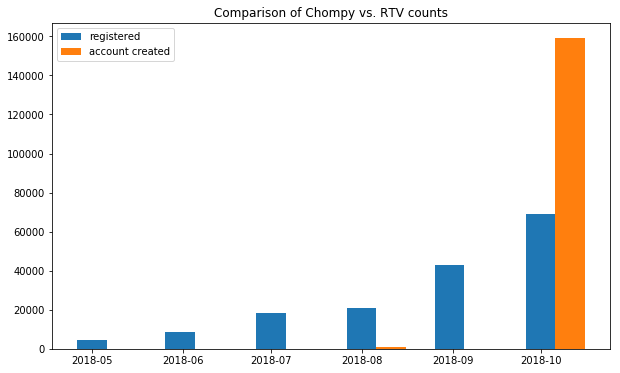

In [51]:
fig, ax = plt.subplots()
ax.bar(
    merged_df['timestamp'].values - pd.Timedelta(days=30), merged_df['northstar_id_reg'], width=10, label='registered')
ax.bar(
    merged_df['timestamp'].values - pd.Timedelta(days=20), merged_df['northstar_id_chompy'], width=10, label='account created')
ax.legend()
fig.set_size_inches(10, 6)
ax.set_title('Comparison of Chompy vs. RTV counts');

If we were to look at the remaining members who did not actually register to vote in October, did they perform another action that would still make them active that month?

In [52]:
mel_ns_ids = df_mel[(df_mel['source'] == 'rock-the-vote') & (df_mel['action_type'] == 'post') & (
df_mel['timestamp'] >= '2018-10-01')]['northstar_id']

In [53]:
ca_ns_ids = df_ca[
    (df_ca['post_source'] == 'rock-the-vote') & (df_ca['post_created_at'] >= '2018-10-01')]['northstar_id']

In [54]:
mel_remaining_ns_ids = list(set(mel_ns_ids) - set(ca_ns_ids))

In [55]:
len(mel_remaining_ns_ids)

94062

In [56]:
df_mel.head()

,event_id,northstar_id,timestamp,action_type,action_id,source,action_serial_id,channel,len_ns_id
3539488,a6bbe374c565de9342fa51d8ea68fd2d,340749,2018-09-13 16:23:41.231462,bertly_link_preview,10,bertly,30d7b772-a4b3-49ab-9351-aa9f963a8d27,sms,6
5244357,28413a8b5e181bdd735604827a8fd26f,54fa272b469c64d7068b4567,2018-05-15 19:25:41.000000,signup,1,turbovote,9176055,web,24
6496899,aaedec1375b7ad51670c96ff271b3561,54fa272b469c64d7068b4567,2018-05-15 19:25:41.000000,post,2,turbovote,489534,other,24
4868020,f25ef2381c27f754fe1b53916c6cc0ff,54fa272d469c64d7068b4577,2018-09-10 22:28:09.078788,bertly_link_preview,10,bertly,5aac556e-b594-4f2f-a964-95523c5810f2,sms,24
859255,4cd5b0972e6af977a1fbf7760322ac5c,54fa272e469c64d7068b457e,2018-07-18 01:54:55.000000,messaged_gambit,6,SMS,5b4e9defb6499d00049a85d8,sms,24


In [57]:
df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote') & (df_mel['source'] == 'importer-client')]['action_type'].value_counts()

account_creation    41171
Name: action_type, dtype: int64

The biggest contributor to MAMs is account creation, but these are all generated by an importer-client, suggesting that they were accounts created by us for nonmembers who had registered to vote. Not including those... 

In [58]:
df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote') & (df_mel['source'] != 'importer-client')]['action_type'].value_counts()

bertly_link_click      9670
clicked_link           5382
site_access            3636
signup                 3238
bertly_link_preview    3185
messaged_gambit        2511
site_login             1855
post                    562
account_creation        141
Name: action_type, dtype: int64

In [59]:
print('Count if we include importer-client account creation: ', len(df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote')
]['northstar_id'].unique()))

print('Count if we do not include those: ', len(df_mel[
    df_mel['northstar_id'].isin(mel_remaining_ns_ids) & 
    (df_mel['timestamp'] >= '2018-10-01') & 
    (df_mel['source'] != 'rock-the-vote') & 
    (df_mel['source'] != 'importer-client')
]['northstar_id'].unique()))

Count if we include importer-client account creation:  48123
Count if we do not include those:  7384


In [60]:
mam_count_bymonth = df_mel.set_index('timestamp').groupby(
    pd.Grouper(freq='M')).agg({'northstar_id': lambda x: len(x.unique())})

In [61]:
mam_count_bymonth

,northstar_id
timestamp,
2018-01-31,260189
2018-02-28,226427
2018-03-31,216263
2018-04-30,141322
2018-05-31,95034
2018-06-30,129257
2018-07-31,193245
2018-08-31,226623
2018-09-30,231882


In [62]:
mam_count_byactivity_oct = df_mel[df_mel['timestamp'] > '2018-10-01'].groupby(
    'action_type').agg({'northstar_id': lambda x: len(x.unique())})

In [63]:
mam_count_byactivity_oct

,northstar_id
action_type,
account_creation,117187
bertly_link_click,53882
bertly_link_preview,80629
clicked_link,19006
messaged_gambit,22134
post,165486
signup,192489
site_access,47054
site_login,43942


In [64]:
# remove rock-the-vote users if they did not actually register in October
df_mel_oct = df_mel[(df_mel['timestamp'] >= '2018-10-01')]

df_mel_oct_reduced = df_mel_oct[~(
    df_mel_oct['northstar_id'].isin(mel_remaining_ns_ids) &
    (df_mel_oct['source'] == 'rock-the-vote'))]

In [65]:
len(df_mel_oct_reduced['northstar_id'].unique())

284306

In [66]:
# remove rock-the-vote users and those whose actions were an account created by an importer-client
df_mel_oct_reduced_2 = df_mel_oct[~(
    df_mel_oct['northstar_id'].isin(mel_remaining_ns_ids) & 
    ((df_mel_oct['source'] == 'rock-the-vote') | (df_mel_oct['source'] == 'importer-client')))]

In [67]:
len(df_mel_oct_reduced_2['northstar_id'].unique())

243567

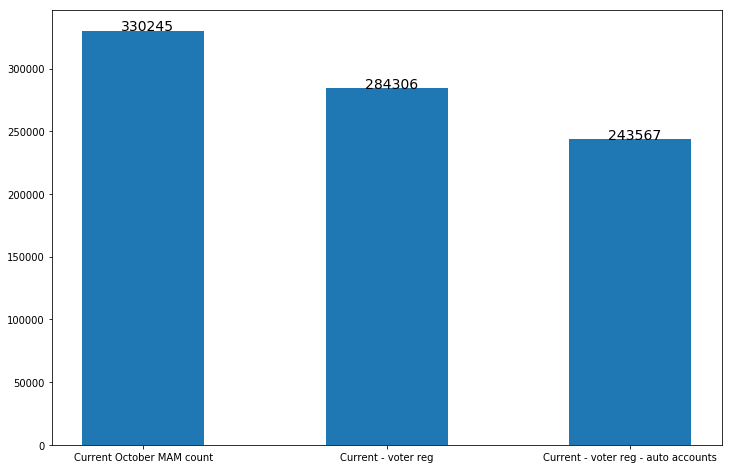

In [68]:
# plot to look at impact on October

fig1, ax1 = plt.subplots()
ax1.bar(x=[0, 1, 2], 
        height=[
            mam_count_bymonth.iloc[-1], 
            len(df_mel_oct_reduced['northstar_id'].unique()), 
            len(df_mel_oct_reduced_2['northstar_id'].unique())],
        width=0.5
       )
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Current October MAM count', 'Current - voter reg', 'Current - voter reg - auto accounts'])
ax1.text(-0.09, mam_count_bymonth.iloc[-1], s=str(mam_count_bymonth.iloc[-1].values[0]), fontsize=14)
ax1.text(0.91, len(df_mel_oct_reduced['northstar_id'].unique()), 
         s=str(len(df_mel_oct_reduced['northstar_id'].unique())), fontsize=14)
ax1.text(1.91, len(df_mel_oct_reduced_2['northstar_id'].unique()), 
         s=str(len(df_mel_oct_reduced_2['northstar_id'].unique())), fontsize=14);


In [69]:
mam_count_bymonth_updated = mam_count_bymonth.copy()

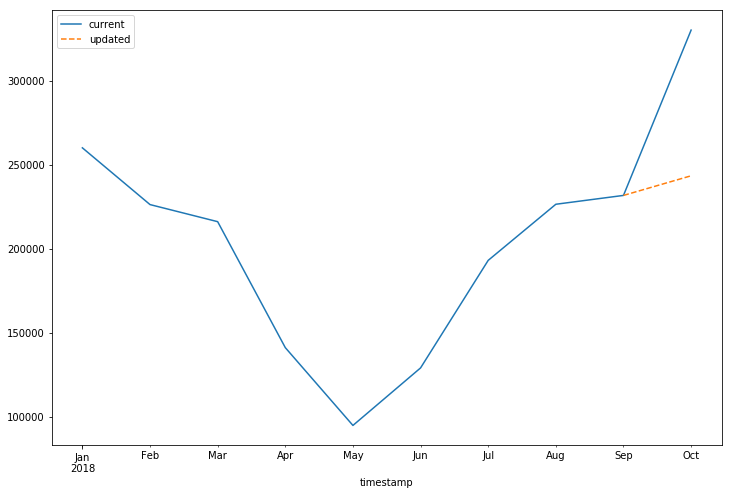

In [70]:
fig2, ax2 = plt.subplots()
mam_count_bymonth.plot(ax=ax2)
mam_count_bymonth_updated.iloc[-1] = len(df_mel_oct_reduced_2['northstar_id'].unique())
mam_count_bymonth_updated.iloc[-2:].plot(ax=ax2, linestyle='dashed')
ax2.legend(labels=['current', 'updated'])

What caused the dip in MAMs in April/May/June?